In [1]:
# Imports and scripts
#import pandas as pd
import modin.pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pathmagic
%matplotlib inline
with pathmagic.context():
    import Preprocess as Prep
    import RelativePaths as RP
    import Evaluation as Eva
    import GatherData as Gather
    import Graphs
    import Utils
import ray
ray.shutdown()
ray.init()

system = 'prom'

[nltk_data] Downloading package stopwords to /home/alex/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
2021-05-10 05:54:14,696	INFO services.py:1172 -- View the Ray dashboard at http://127.0.0.1:8268


In [2]:
# File containing settings
path_to_yaml = '../config.yaml'
config = Utils.read_yaml_file(path_to_yaml)

files = config['file locations'][system]
preprocess_settings = config['preprocess settings list']

In [3]:
# set file_locations which will be relative to computer in use
from pathlib import Path
raw_data_csv = str(Path.cwd().parent / files['raw data'])
system_folder = str(Path.cwd().parent / files['system folder'])
tmp_csv = str(Path.cwd().parent / files['tmp data'])
table_file = str(Path.cwd().parent / files['preprocess comparisons'])

In [4]:
Gather.gather_architectural_concerns_data(system_folder, raw_data_csv)

To request implementation, send an email to feature_requests@modin.org.


Text(0.5, 1.0, 'File distribution of the software architectural concerns for prom')

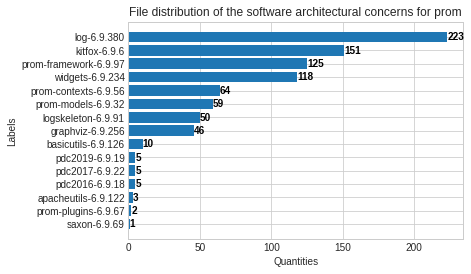

In [5]:
dataset_df = pd.read_csv(raw_data_csv)
y_labels = dataset_df.Label.unique()
x_quantity = [len(dataset_df.loc[dataset_df['Label']==label]) for label in y_labels]
tmp_df = pd.DataFrame({
    'Labels' : y_labels,
    'Quantity' : x_quantity
})
tmp_df = tmp_df.sort_values(by=['Quantity'])
plt.style.use("seaborn-whitegrid")
plt.barh(y=tmp_df.Labels, width=tmp_df.Quantity)
for i, v in enumerate(tmp_df.Quantity):
    plt.text(v, i, str(v), color='black', fontweight='bold', ha='left', va='center')

plt.xlabel('Quantities')
plt.ylabel('Labels')
plt.title('File distribution of the software architectural concerns for ' + system)

In [6]:
df_columns = [
    'classifier',
    'setting_id',
    'Feature rep.',
    'settings', 
    'accuracy', 
    'macro_precision', 
    'macro_recall',
    'weighted_precision',
    'weighted_recall',
    'macro_f1',
    'weighted_f1',
    'train_size', 
    'test_size', 
    'report_table' 
]
main_table = pd.DataFrame(columns=df_columns)
test_size=0.9
fold_quantity = 100

for setting_id, setting in preprocess_settings.items():
    Prep.preprocess_settings(setting, raw_data_csv, tmp_csv)
    tmp_df = pd.read_csv(tmp_csv)

    # Remove GLOBALS and CLI from the dataset
    df_sliced = Utils.remove_concerns_under_quantity_threshold(tmp_df)

    feature_bow = CountVectorizer()
    feature_tfidf = TfidfVectorizer(use_idf = True)
    confusion_list = []

    # Train and gather evaluation metrics with Bag-Of-Words
    evaluate = Eva.Evaluation(df_sliced, feature_bow, test_size, fold_quantity, 10)
    classifier_max_ent , metrics_max_ent = evaluate.evaluate_MaxEnt()
    classifier_svm , metrics_svm = evaluate.evaluate_SVM()
    classifier_naive, metrics_naive = evaluate.evaluate_Naive_Bayes()
    
    
    row = Utils.make_dataframe_row(metrics_max_ent, setting, "Bag-of-words", setting_id)
    main_table = main_table.append(row, ignore_index=True)

    row = Utils.make_dataframe_row(metrics_svm, setting, "Bag-of-words", setting_id)
    main_table = main_table.append(row, ignore_index=True)
    
    row = Utils.make_dataframe_row(metrics_naive, setting, "Bag-of-words", setting_id)
    main_table = main_table.append(row, ignore_index=True)
                                     

    # Train and gather evaluation metrics with TF-IDF
    evaluate = Eva.Evaluation(df_sliced, feature_tfidf, test_size, fold_quantity, 10)
    classifier_max_ent , metrics_max_ent = evaluate.evaluate_MaxEnt()
    classifier_svm , metrics_svm = evaluate.evaluate_SVM()
    classifier_naive, metrics_naive = evaluate.evaluate_Naive_Bayes()
    
    
    row = Utils.make_dataframe_row(metrics_max_ent, setting, "TF-IDF", setting_id)
    main_table = main_table.append(row, ignore_index=True)

    row = Utils.make_dataframe_row(metrics_svm, setting, "TF-IDF", setting_id)
    main_table = main_table.append(row, ignore_index=True)
    
    row = Utils.make_dataframe_row(metrics_naive, setting, "TF-IDF", setting_id)
    main_table = main_table.append(row, ignore_index=True)


main_table.to_csv(table_file, index=False)

2021-05-10 06:26:16,211	WARNING worker.py:1107 -- WARNING: 36 PYTHON workers have been started. This could be a result of using a large number of actors, or it could be a consequence of using nested tasks (see https://github.com/ray-project/ray/issues/3644) for some a discussion of workarounds.


In [7]:
print(table_file)
main_table
df = pd.read_csv(table_file)
df
df.sort_values(by='accuracy',ascending=[False])

/home/alex/ExtraSpace/study/DVGC25/repository/BSc-JavSoCoClassifier/Data/prom/prep_comparisons.csv


,classifier,setting_id,Feature rep.,settings,accuracy,macro_precision,macro_recall,weighted_precision,weighted_recall,macro_f1,weighted_f1,train_size,test_size,report_table
4,SVM,s0,TF-IDF,"[['lib', 'tow', 'scw', 'jk', 'lc', 'stem'], ['...",0.832021,0.789049,0.774519,0.848429,0.832021,0.776224,0.835503,84,762,basicutils-6.9.126 graphviz-6.9.25...
28,SVM,s4,TF-IDF,"[['lib', 'tow', 'scw', 'jk', 'lc', 'stem'], ['...",0.830709,0.733605,0.778889,0.847379,0.830709,0.749447,0.832889,84,762,basicutils-6.9.126 graphviz-6.9.25...
5,Naive-Bayes,s0,TF-IDF,"[['lib', 'tow', 'scw', 'jk', 'lc', 'stem'], ['...",0.829396,0.852290,0.766867,0.842896,0.829396,0.787069,0.830306,84,762,basicutils-6.9.126 graphviz-6.9.25...
29,Naive-Bayes,s4,TF-IDF,"[['lib', 'tow', 'scw', 'jk', 'lc', 'stem'], ['...",0.828084,0.850137,0.754084,0.840699,0.828084,0.770971,0.827974,84,762,basicutils-6.9.126 graphviz-6.9.25...
3,MaxEnt,s0,TF-IDF,"[['lib', 'tow', 'scw', 'jk', 'lc', 'stem'], ['...",0.828084,0.768825,0.794676,0.844184,0.828084,0.777262,0.830110,84,762,basicutils-6.9.126 graphviz-6.9.25...
0,MaxEnt,s0,Bag-of-words,"[['lib', 'tow', 'scw', 'jk', 'lc', 'stem'], ['...",0.824147,0.759553,0.758597,0.850686,0.824147,0.745920,0.824029,84,762,basicutils-6.9.126 graphviz-6.9.25...
27,MaxEnt,s4,TF-IDF,"[['lib', 'tow', 'scw', 'jk', 'lc', 'stem'], ['...",0.822835,0.745783,0.752230,0.835671,0.822835,0.743057,0.822813,84,762,basicutils-6.9.126 graphviz-6.9.25...
24,MaxEnt,s4,Bag-of-words,"[['lib', 'tow', 'scw', 'jk', 'lc', 'stem'], ['...",0.820210,0.736978,0.707769,0.836000,0.820210,0.705708,0.815656,84,762,basicutils-6.9.126 graphviz-6.9.25...
16,SVM,s2,TF-IDF,"[['lib', 'tow', 'scw', 'jk', 'lc', 'stem'], ['...",0.808399,0.842712,0.714657,0.836694,0.808399,0.732633,0.811129,84,762,basicutils-6.9.126 graphviz-6.9.25...
15,MaxEnt,s2,TF-IDF,"[['lib', 'tow', 'scw', 'jk', 'lc', 'stem'], ['...",0.807087,0.796457,0.759271,0.823572,0.807087,0.759391,0.802593,84,762,basicutils-6.9.126 graphviz-6.9.25...


2021-05-10 06:26:20,534	ERROR worker.py:1053 -- Possible unhandled error from worker: ray::deploy_ray_func() (pid=3332155, ip=10.8.8.49)
  File "python/ray/_raylet.pyx", line 480, in ray._raylet.execute_task
  File "/home/alex/dotfiles/python_venvs/exjobb_labEnv/lib/python3.8/site-packages/modin/engines/ray/pandas_on_ray/frame/axis_partition.py", line 114, in deploy_ray_func
    result = func(*args)
  File "/home/alex/dotfiles/python_venvs/exjobb_labEnv/lib/python3.8/site-packages/modin/engines/base/frame/axis_partition.py", line 294, in deploy_axis_func
    if sum(lengths) != len(result.columns):
AttributeError: 'int' object has no attribute 'columns'
2021-05-10 06:26:20,535	ERROR worker.py:1053 -- Possible unhandled error from worker: ray::deploy_ray_func() (pid=3332154, ip=10.8.8.49)
  File "python/ray/_raylet.pyx", line 480, in ray._raylet.execute_task
  File "/home/alex/dotfiles/python_venvs/exjobb_labEnv/lib/python3.8/site-packages/modin/engines/ray/pandas_on_ray/frame/axis_parti